Mean Squared Error: 131.68737098091526


/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_17617/582410424.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


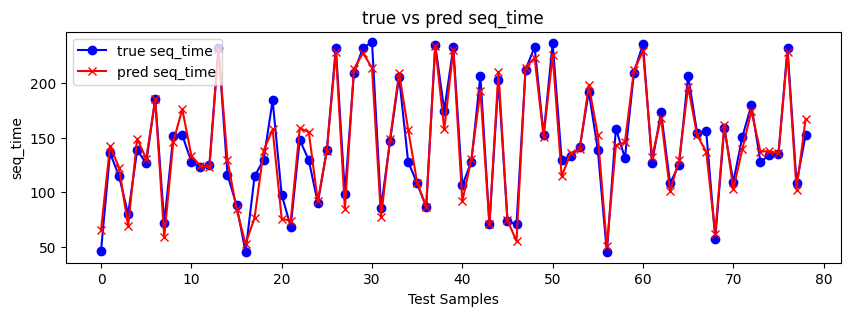

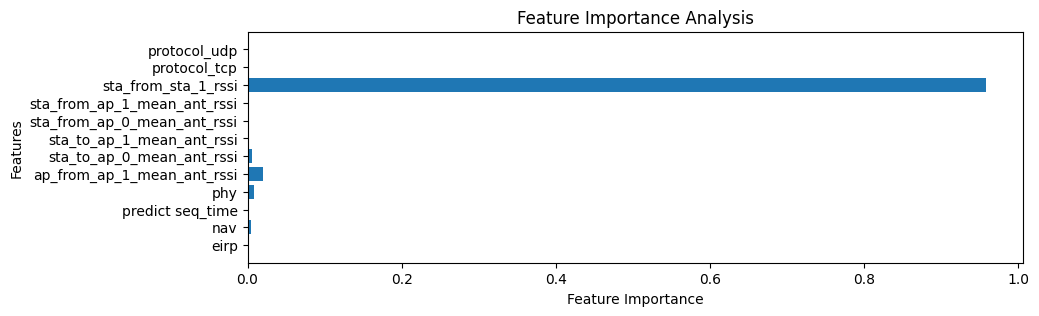

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


def fill_missing_values(df):
    # 填充空值
    for column in df.columns:
        if df[column].isnull().all():
            if df[column].dtype == "object":
                df[column].fillna(0, inplace=True)
            else:
                df[column].fillna(0, inplace=True)
        elif df[column].dtype == "object":
            df[column].fillna(df[column].mode()[0], inplace=True)
        elif pd.api.types.is_numeric_dtype(df[column]):
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            df[column].fillna(method="ffill", inplace=True)
    return df


def get_phy_value(nss, mcs):
    if nss == 1:
        return phy_table.loc[phy_table["MCS"] == mcs, "NSS1"].values[0]
    elif nss == 2:
        return phy_table.loc[phy_table["MCS"] == mcs, "NSS2"].values[0]
    else:
        return None


def get_files_by_keywords(directory, keywords):
    # 遍历指定文件夹，根据关键字数组提取文件。
    matched_files = []
    for filename in os.listdir(directory):
        if all(keyword in filename for keyword in keywords):
            matched_files.append(filename)
    return matched_files


def process_array_string(array_string):
    # 去掉最大值、最小值并计算平均值
    # 如果输入是单个值，则直接返回
    if isinstance(array_string, (int, float)):
        return array_string
    # 将字符串转换为列表
    values = ast.literal_eval(array_string)
    # 如果列表长度大于2，去掉最大值和最小值
    if len(values) > 2:
        values.remove(max(values))
        values.remove(min(values))
    mean_value = np.mean(values)
    return mean_value


##### 修改这里 #####
ap_name = "2ap"
project_root = "/Users/daylight/Desktop/macos/1Code/Competition/2024ShuMo"
data_dir = project_root + "/data/results/question2"
training_data_names = get_files_by_keywords(data_dir, ["training", ap_name, "csv"])
training_data_all_path = project_root + f"/data/processed/training_data_{ap_name}.csv"
os.makedirs(os.path.dirname(training_data_all_path), exist_ok=True)
training_data_names = sorted(training_data_names)
#### 读取所有训练数据 #####
training_data_all = pd.DataFrame()
# 初始化一个变量来追踪全局的最大 test_id
current_max_test_id = 0
file_split_id = []  # 记录分隔文件的id位置
for file in training_data_names:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    # 获取当前合并DataFrame中的最大test_id，如果为空则设置为0
    if not training_data_all.empty:
        max_test_id = training_data_all["test_id"].max()
    else:
        max_test_id = 0
    # 调整新df的test_id，保证test_id连续递增
    df["test_id"] = df["test_id"] + max_test_id
    # 将当前DataFrame追加到总的training_data_all中
    training_data_all = pd.concat([training_data_all, df], ignore_index=True)
    file_split_id.append(training_data_all["test_id"].max())

training_data_all["phy"] = None
columns_class = ["ap_id", "sta_id"]
columns_numerical = ["eirp", "nav", "predict seq_time", "phy"]
columns_basic = ["test_id", "protocol", "nss", "mcs", "throughput"] + columns_numerical
# protocol_name = ["tcp", "udp"]

### 提取对应的列rssi ###
ap_0_sta_0 = ["ap_from_ap_1_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_sta_1_rssi"]
ap_1_sta_1 = ["ap_from_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_sta_0_rssi"]
training_data_all_ap_0 = training_data_all.loc[training_data_all["ap_id"] == "ap_0"].copy()
for i, column in enumerate(ap_0_sta_0):
    training_data_all_ap_0[column] = training_data_all_ap_0[column].apply(process_array_string)

training_data_all_ap_1 = training_data_all.loc[training_data_all["ap_id"] == "ap_1"].copy()
for i, column in enumerate(ap_1_sta_1):
    training_data_all_ap_1[ap_0_sta_0[i]] = training_data_all_ap_1[column].apply(process_array_string)

training_data_all_processed = pd.concat([training_data_all_ap_0[columns_basic + ap_0_sta_0], training_data_all_ap_1[columns_basic + ap_0_sta_0]], ignore_index=True)
phy_table = pd.DataFrame({"MCS": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], "NSS1": [8.6, 17.2, 25.8, 34.4, 51.6, 68.8, 77.4, 86.0, 103.2, 114.7, 129.0, 143.4], "NSS2": [17.2, 34.4, 51.6, 68.8, 103.2, 137.6, 154.9, 172.1, 206.5, 229.4, 258.1, 286.8]})
training_data_all_processed["phy"] = training_data_all_processed.apply(lambda row: get_phy_value(row["nss"], row["mcs"]), axis=1)

######## 训练模型 #######
random_state_num = 1929
training_data = training_data_all_processed.loc[:, columns_basic + ap_0_sta_0].copy()
# 编码非数值变量
training_data_encoded = pd.get_dummies(training_data, columns=["protocol"])
training_data_encoded = fill_missing_values(training_data_encoded)
# 拼接向量
X = training_data_encoded[columns_numerical + ap_0_sta_0 + [col for col in training_data_encoded.columns if col.startswith("protocol_")]]
y = training_data_encoded["throughput"]


# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_num)

# 归一化特征
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 模型训练 ####
# 线性回归
# model = LinearRegression()
# XGBoost
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=random_state_num)
# 随机森林
# model = RandomForestRegressor(random_state=random_state)
# 支持向量回归
# model = SVR(kernel='rbf')
# 神经网络回归模型
# model = MLPRegressor(hidden_layer_sizes=(128,64,32), max_iter=1000, alpha=0.001, random_state=random_state)

# 训练模型
model.fit(X_train_scaled, y_train)
# 对测试集进行预测
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 对比曲线图：真实值 vs 预测值
plt.figure(figsize=(10, 3))
plt.plot(np.arange(len(y_test)), y_test, label="true seq_time", color="blue", marker="o")
plt.plot(np.arange(len(y_pred)), y_pred, label="pred seq_time", color="red", marker="x")
plt.xlabel("Test Samples")
plt.ylabel("seq_time")
plt.title("true vs pred seq_time")
plt.legend()
plt.show()

#### 只有树模型才有
# 打印每个特征的重要性
importance = model.feature_importances_
# 可视化特征重要性
plt.figure(figsize=(10, 3))
plt.barh(X_train.columns, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Analysis")
plt.show()

In [14]:
###### 预测，将训练集也预测用于question2 #######
test_data_names = get_files_by_keywords(data_dir, [ap_name, "csv"])
test_data_names = sorted(test_data_names)
question1_results_dir = project_root + "/data/results/question3"
os.makedirs(question1_results_dir, exist_ok=True)
for test_data_name in test_data_names:
    file_path = os.path.join(data_dir, test_data_name)
    test_data_all = pd.read_csv(file_path)
    test_data_all["phy"] = None

    test_data_ap_0 = test_data_all.loc[test_data_all["ap_id"] == "ap_0"].copy()
    for i, column in enumerate(ap_0_sta_0):
        test_data_ap_0[column] = test_data_ap_0[column].apply(process_array_string)

    test_data_ap_1 = test_data_all.loc[test_data_all["ap_id"] == "ap_1"].copy()
    for i, column in enumerate(ap_1_sta_1):
        test_data_ap_1[ap_0_sta_0[i]] = test_data_ap_1[column].apply(process_array_string)

    test_data_processed = pd.concat([test_data_ap_0[columns_basic + ap_0_sta_0], test_data_ap_1[columns_basic + ap_0_sta_0]], ignore_index=True)

    ####### 预测数据 ########
    test_data = test_data_processed.loc[:, columns_basic + ap_0_sta_0].copy()
    # 编码非数值变量
    test_data_encoded = pd.get_dummies(test_data, columns=["protocol"])
    X_test_data = test_data_encoded[columns_numerical + ap_0_sta_0 + [col for col in test_data_encoded.columns if col.startswith("protocol_")]]

    X_test_data = fill_missing_values(X_test_data)
    # 对测试数据进行归一化（使用与训练集相同的 scaler）
    X_test_final_scaled = scaler.transform(X_test_data)
    # 使用训练好的模型进行预测
    y_test_pred = model.predict(X_test_final_scaled)
    # 输出预测结果
    test_data_all["predict throughput"] = y_test_pred
    test_data_all.to_csv(f"{question1_results_dir}/{test_data_name}", index=False)
    # test_data["predict seq_time"] = y_test_pred

    # plt.figure(figsize=(10, 3))
    # plt.plot(np.arange(len(test_data["predict seq_time"])), test_data["predict seq_time"], label="predict seq_time")
    # plt.plot(np.arange(len(test_data["ap_from_ap_1_mean_ant_rssi"])), test_data["ap_from_ap_1_mean_ant_rssi"], label="ap_from_ap_1_mean_ant_rssi")
    # plt.legend()
    # plt.show()

/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_17617/582410424.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_17617/582410424.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].mean(), i